In [24]:
import os
import glob
import torch
import torch.nn.functional as F
import torch.nn as nn
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict, OrderedDict
import matplotlib
from matplotlib.gridspec import GridSpec
import sys
import random
from utils import *
import copy
import pandas as pd

sys.path.append('.')
plt.rcParams.update(plt.rcParamsDefault)
font = {'family' : 'serif', 'size':12}
plt.rc('font', **font)
plt.rc("lines", linewidth=3.0)
plt.rcParams["savefig.dpi"] = 500
cmap = plt.get_cmap('plasma')

savedir = './figs/mathematica/'
datadir = './data/'

# Analytical spectra

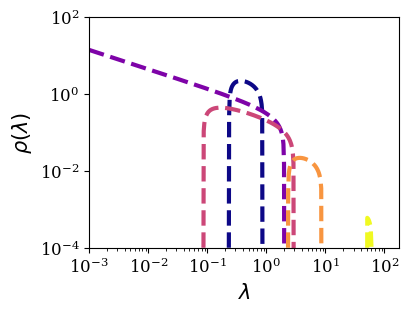

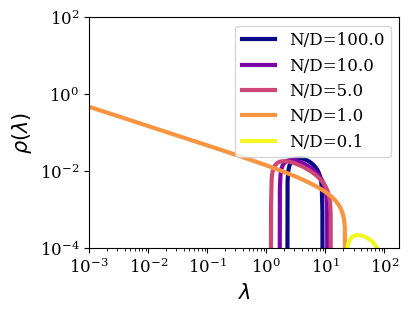

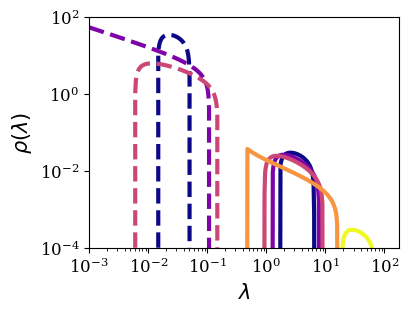

In [32]:
def plot_spectra(dic):

    for i, (r, data) in enumerate(dic.items()):
        plt.figure(figsize=(4,3))
        for j, (phi,spectrum) in enumerate(data.items()):
            lam = 10**spectrum[:,0]
            density = spectrum[:,1]       
            if float(r)>0 and float(r)<1:
                linear_mask = density>0.2
                plt.loglog(lam, density*linear_mask,    color=cmap(j/(len(data)-1)), label='N/D={}'.format(1/phi), ls='--')
                plt.loglog(lam, density*(1-linear_mask), color=cmap(j/(len(data)-1)), label='N/D={}'.format(1/phi))
            elif float(r)==1:
                plt.loglog(lam, density, color=cmap(j/(len(data)-1)), label='N/D={}'.format(1/phi))
            elif float(r)==0:
                plt.loglog(lam, density, color=cmap(j/(len(data)-1)), label='N/D={}'.format(1/phi), ls='--')
            plt.ylim(1e-4, 1e2)
            plt.xlabel(r'$\lambda$', fontsize=15)
            plt.ylabel(r'$\rho(\lambda)$', fontsize=15)
            plt.xlim(left=min(lam))
        if float(r)==1: 
            plt.legend()
        plt.savefig(savedir+'spectrum_{}.pdf'.format(r), bbox_inches='tight')
    plt.show()
    
dic=defaultdict(dict)

for file in glob.glob(datadir+'*.json'):
    if 'spectrum' not in file: continue
    data = pd.read_json(file)
    data = np.array(data)
    r = file.split('_')[-1].rstrip('.json')
    for data_tmp in data:
        phi = data_tmp[0]
        dic[r][phi]= np.array([data_tmp[lam] for lam in range(1,len(data_tmp))])
torch.save(dic, datadir+'spectra.pyT')

plot_spectra(dic)

# Bias-variance

In [26]:
def get_plot(highreg, k, tau, legend=False):
    dic = {}
    data = pd.read_json(datadir+'error_{}.json'.format('highreg' if highreg else 'lowreg'))
    data = np.array(data)
    logpsi2s = np.array([data[0,j][0] for j in range(len(data[0]))])
    psis = np.array([[data[i,j][1] for j in range(len(data[0]))] for i in range(len(data))])
    plot_terms(logpsi2s, psis, k=k, tau=tau, 
           savename=savedir+'bias_var_tau{}_k{}_{}.pdf'.format(tau,k,'highreg' if highreg else 'lowreg'),
          legend=legend)

def get_data(highreg):
    dic = {}
    data = pd.read_json(datadir+'error_{}.json'.format('highreg' if highreg else 'lowreg'))
    data = np.array(data)
    logpsi2s = np.array([data[0,j][0] for j in range(len(data[0]))])
    psis = np.array([[data[i,j][1] for j in range(len(data[0]))] for i in range(len(data))])

def get_terms(psis, k, tau):
    var_init = (psis[1]-psis[3])/k
    var_nois = tau**2*((psis[2]-psis[4])/k+psis[4])
    var_samp = psis[3] - psis[5]
    bias     = 1-2*psis[0] + psis[5]
    total = var_init + var_nois + var_samp + bias
    return var_init, var_nois, var_samp, bias, total

def plot_terms(logpsi2s, psis, k, tau, savename, legend=True):
    var_init, var_nois, var_samp, bias, total = get_terms(psis, k, tau)
    plt.figure(figsize=(6,3))
    psi2s = 10**logpsi2s
    plt.plot(psi2s, var_init, label='init')
    plt.plot(psi2s, var_nois, label='noise')
    plt.plot(psi2s, var_samp, label='samp')
    plt.plot(psi2s, bias, label='bias')
    plt.plot(psi2s, total, label='total', color='k', ls='--')
    plt.axvline(x=1, color='grey', label='N=D')
    plt.axvline(x=100, color='grey', ls='--', label='N=P')
    if legend: plt.legend(loc='upper right')
    plt.ylim(bottom=1e-5, top=1e2)
    plt.xlabel('N/D')
    plt.xscale('log')
    plt.yscale('log')
    plt.tight_layout()
    plt.savefig(savename)
    plt.show()  

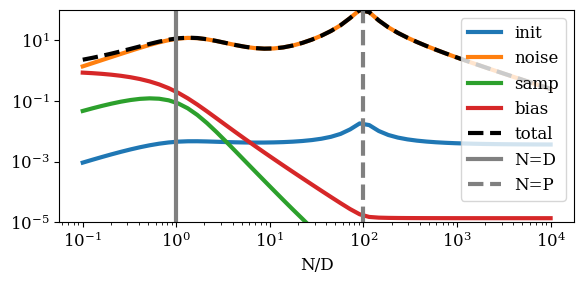

In [27]:
highreg=False
k = 1
tau = 5
get_plot(highreg, k, tau, legend=True)

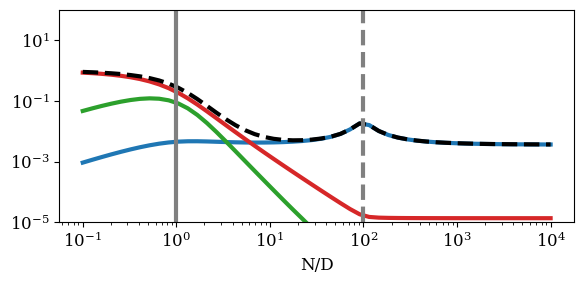

In [28]:
highreg=False
k = 1
tau = 0
get_plot(highreg, k, tau)

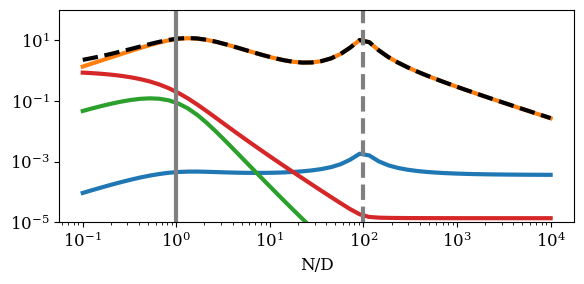

In [29]:
highreg=False
k = 10
tau = 5
get_plot(highreg, k, tau)

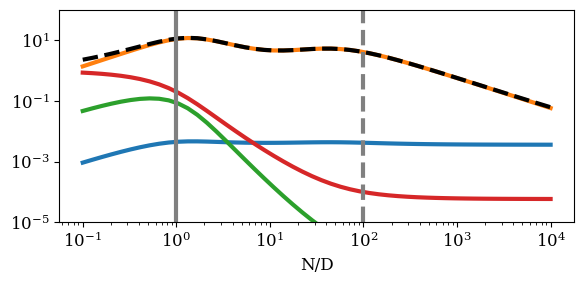

In [30]:
highreg=True
k = 1
tau = 5
get_plot(highreg, k, tau)